# Benchmarks

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [65]:
df = pd.read_csv('../data/NBA Scores and Point Spreads.csv')

In [146]:
data = (
    df
    .assign(
        mov_vs_spread = lambda x: x['mov'] + x['point_spread'],
        predicted_winner = lambda x: x['point_spread'].transform(lambda s: True if s < 0 else False),
        actual_winner = lambda x: x['mov'].transform(lambda s: True if s >0 else False),
        line_right = lambda x: x['predicted_winner'] == x['actual_winner'],
        train_test = lambda x: x['game_number'].transform(lambda s: 'Train' if s <= 20 else 'Test'),
        delta = lambda x: abs(x['mov_vs_spread']),
        delta_squared = lambda x: x['delta'] ** 2,
        Era = lambda x: x['season'].apply(lambda s: 'Pre 2016' if s < "2016-17" else 'Modern')
    )
    .query('home_away == "Home"')
)

data.sample(20)

,team,team_points,opponent,opponent_points,point_spread,file_name,game_id,season,dt,home_away,mov,game_number,mov_vs_spread,predicted_winner,actual_winner,line_right,train_test,delta,delta_squared,Era
33681,Chicago,122,Sacramento,114,0.0,nba odds 2020-21.xlsx,5c4506dc6f5edea62c7b0c675f65803f,2020-21,2021-02-20,Home,8,29.0,8.0,False,True,False,Test,8.0,64.00,Modern
641,Detroit,93,Utah,103,1.0,nba odds 2007-08.xlsx,9054296ea7b73366e60a49c9422a9750,2007-08,2007-11-25,Home,-10,13.0,-9.0,False,False,True,Train,9.0,81.00,Pre 2016
11017,Detroit,89,Orlando,78,5.0,nba odds 2011-12.xlsx,e755f3af37b328031b00009f26798064,2011-12,2012-01-02,Home,11,5.0,16.0,False,True,False,Train,16.0,256.00,Pre 2016
14427,NewYork,105,Indiana,79,-5.5,nba odds 2012-13.xlsx,1004f7968ec0bd20089f68528d23dacd,2012-13,2013-05-07,Home,26,90.0,20.5,True,True,True,Test,20.5,420.25,Pre 2016
24661,Milwaukee,89,Charlotte,79,-6.5,nba odds 2016-17.xlsx,bd38dfc97cf2722e950c6a09459d9c3b,2016-17,2017-04-10,Home,10,81.0,3.5,True,True,True,Test,3.5,12.25,Modern
5203,Washington,103,Philadelphia,109,1.5,nba odds 2008-09.xlsx,65cf887e3422fe20b2f4153177e22e22,2008-09,2008-12-19,Home,-6,24.0,-4.5,False,False,True,Test,4.5,20.25,Pre 2016
24515,Miami,104,Boston,112,4.5,nba odds 2016-17.xlsx,b513980bbdbe68f5e6298e9b81e4d391,2016-17,2016-11-28,Home,-8,17.0,-3.5,False,False,True,Train,3.5,12.25,Modern
11174,Houston,96,OklahomaCity,95,2.5,nba odds 2011-12.xlsx,e3a2ef9368eb9b1325fd17976c02f5b8,2011-12,2012-02-15,Home,1,30.0,3.5,False,True,False,Test,3.5,12.25,Pre 2016
3241,Denver,106,Portland,90,-7.5,nba odds 2008-09.xlsx,2ba9a10e92b48c2d42f7b1750e443fda,2008-09,2009-03-05,Home,16,62.0,8.5,True,True,True,Test,8.5,72.25,Pre 2016
35111,Philadelphia,129,Washington,112,-6.0,nba odds 2020-21.xlsx,298a9c6f4ca79924f1f894e0ee8b3f5a,2020-21,2021-06-02,Home,17,77.0,11.0,True,True,True,Test,11.0,121.00,Modern


In [175]:
batting_average = (
    data
    .groupby(['Era', 'game_number', 'line_right'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .assign(
        cumulative_mean = lambda x: x.groupby(['Era', 'line_right'])['games'].transform(lambda s: s.expanding().mean())
    )
    .pivot_table(
        index=['Era', 'game_number'],
        columns='line_right',
        values='cumulative_mean'
    )
    .reset_index()
    .set_axis(['Era', 'game_number', 'incorrect', 'correct'], axis=1)
    .assign(
        total = lambda x: x['incorrect'] + x['correct'],
        BattingAverage = lambda x: 100 * x['correct'] / x['total']
    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['Era', 'game_number', 'BattingAverage']]
)

mae = (
    data
    .groupby(['Era', 'game_number'])
    .agg(
        games = ('game_id', 'count'),
        total_delta = ('delta', 'sum'),
    )
    .reset_index()
    .assign(
        rolling_games = lambda x: x.groupby('Era')['games'].transform(lambda s: s.expanding().sum()),
        rolling_delta = lambda x: x.groupby('Era')['total_delta'].transform(lambda s: s.expanding().sum()),
        MAE = lambda x: x['rolling_delta'] / x['rolling_games'],
    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['Era', 'game_number', 'MAE',]]
)

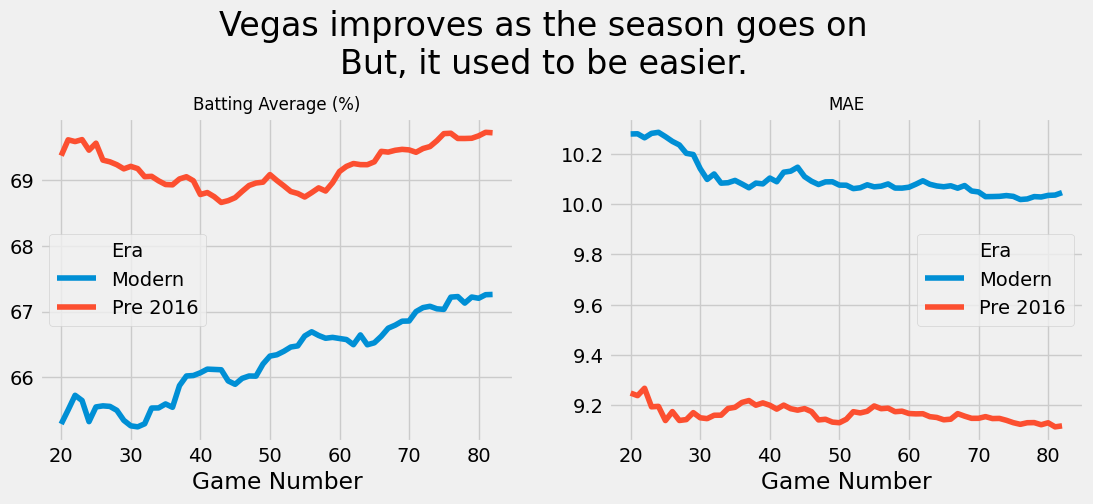

In [176]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))

(
    batting_average
    .pivot_table(
        index='game_number',
        columns='Era',
        values='BattingAverage'
    )
    .plot(
        ax=ax1
    )
)

ax1.set_title('Batting Average (%)', size=12)
ax1.set_xlabel('Game Number')

(
    mae_and_rmse
    .pivot_table(
        index='game_number',
        columns='Era',
        values='MAE'
    )
    .plot(
        ax=ax2
    )
)

ax2.set_title('MAE', size=12)
ax2.set_xlabel('Game Number')


plt.suptitle('Vegas improves as the season goes on\nBut, it used to be easier.', size=24, y=1.15)
plt.show()